In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from models.Resnet50_multiply_truncated import resnet50_multiply
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from preprocessing import parse_aug_fn, parse_fn

In [2]:
img_size = 64
batch_size = 20

In [3]:
# 先把根目錄用到food11
import os
# load dataset
dataset_dir = './food11'
# create new dir
try:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(11):
        os.mkdir(f'train/{i:02d}')
        os.mkdir(f'valid/{i:02d}')
except:
    pass

# create new file structure for dataset
for index, sub_dir in enumerate(['training', 'validation', 'test']):
    target_dir = os.path.join(dataset_dir, sub_dir)
    img_list = os.listdir(target_dir)
    for img_name in img_list:
        category, *r = img_name.split('_')
        img_path = os.path.join(target_dir, img_name)
        string = ""
        for j in range(4):
            if category[j]!='0':
                string += category[j]
        category = int(string)
        if index == 2:
            new_fn = f'test/{img_name}'
        else:
            new_fn = f'{sub_dir[:5]}/{category:02d}/{img_name}'
        os.rename(img_path, new_fn)

In [4]:
# Dataset preprocessing
batch_size = 25
data_transform = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #image augmentation
train_data = data_transform.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='sparse')
valid_data = data_transform.flow_from_directory(
        'valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='sparse')
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    image_size=(299,299),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
test_data = test_set.map(lambda x: (tf.divide(x, 255)))

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 files belonging to 1 classes.


In [5]:
pre_trained_model = InceptionV3(input_shape=(299, 299, 3), include_top = False, weights = 'imagenet')
last_layer = pre_trained_model.get_layer('mixed10') #引入mixed8以前InceptionV3的layer和權重 
last_output = last_layer.output
last_output = layers.Dropout(0.3)(last_output)
outputs = resnet50_multiply(last_output)
model_4 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=outputs, name='Resnet50_multiply')
model_4.summary()
plot_model(model_4, to_file='models\ResNet50_multiply_truncated.png', show_shapes=True)

Model: "Resnet50_multiply"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________

In [6]:
##調整學習率，採用學習率隨epoch數上升呈遞減的狀態，避免一開始學習過慢，之後overshooting的情形
starter_learning_rate = 1e-2
end_learning_rate = 1e-3
decay_steps = 3000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=0.6, cycle=True)
model_dir=r'.\models\Resnet50_multiply_TL'
os.makedirs(model_dir)
log_dir = os.path.join('exam','model_Resnet50_multiply_TL')
model_cbk=keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp=keras.callbacks.ModelCheckpoint(model_dir + '/Best_exam_model.h5', monitor='val_sparse_categorical_accuracy',save_best_only=True,mode='max')
model_4.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_1=model_4.fit(train_data,epochs=50,validation_data=valid_data,callbacks=[model_cbk,model_mckp])

Epoch 1/50
395/395 [==============================] - 259s 616ms/step - loss: 8.8578 - sparse_categorical_accuracy: 0.1327 - val_loss: 8.3636 - val_sparse_categorical_accuracy: 0.1458
Epoch 2/50
395/395 [==============================] - 241s 611ms/step - loss: 8.6693 - sparse_categorical_accuracy: 0.1422 - val_loss: 8.4492 - val_sparse_categorical_accuracy: 0.1560
Epoch 3/50
395/395 [==============================] - 243s 615ms/step - loss: 8.5304 - sparse_categorical_accuracy: 0.1409 - val_loss: 8.2112 - val_sparse_categorical_accuracy: 0.1458
Epoch 4/50
395/395 [==============================] - 242s 612ms/step - loss: 8.3955 - sparse_categorical_accuracy: 0.1389 - val_loss: 8.1959 - val_sparse_categorical_accuracy: 0.1449
Epoch 5/50
395/395 [==============================] - 244s 618ms/step - loss: 8.2929 - sparse_categorical_accuracy: 0.1494 - val_loss: 8.9460 - val_sparse_categorical_accuracy: 0.1735
Epoch 6/50
395/395 [==============================] - 246s 623ms/step - loss: 8.

395/395 [==============================] - 232s 588ms/step - loss: 5.1889 - sparse_categorical_accuracy: 0.8205 - val_loss: 5.3964 - val_sparse_categorical_accuracy: 0.7697
Epoch 46/50
395/395 [==============================] - 233s 589ms/step - loss: 5.1584 - sparse_categorical_accuracy: 0.8219 - val_loss: 5.4319 - val_sparse_categorical_accuracy: 0.7458
Epoch 47/50
395/395 [==============================] - 234s 592ms/step - loss: 5.1339 - sparse_categorical_accuracy: 0.8225 - val_loss: 5.6857 - val_sparse_categorical_accuracy: 0.6939
Epoch 48/50
395/395 [==============================] - 241s 611ms/step - loss: 5.0542 - sparse_categorical_accuracy: 0.8439 - val_loss: 5.3266 - val_sparse_categorical_accuracy: 0.7729
Epoch 49/50
395/395 [==============================] - 238s 601ms/step - loss: 4.9939 - sparse_categorical_accuracy: 0.8520 - val_loss: 5.3611 - val_sparse_categorical_accuracy: 0.7545
Epoch 50/50
395/395 [==============================] - 234s 593ms/step - loss: 4.9484 -

In [7]:
model_4.load_weights('models\Resnet50_multiply_TL\Best_exam_model.h5')
answer = model_4.predict(test_data)
df = pd.DataFrame()
df["Id"] = ["0"*(4-len(str(i)))+str(i) for i in range(1,np.shape(answer)[0]+1)]
def get_class(i):
    top_1_index = np.argsort(answer[i])[10]
    return top_1_index 
df["Category"] = [get_class(i) for i in range(0,np.shape(answer)[0])]
df.to_csv("test_result\submission_4.csv",index = False)

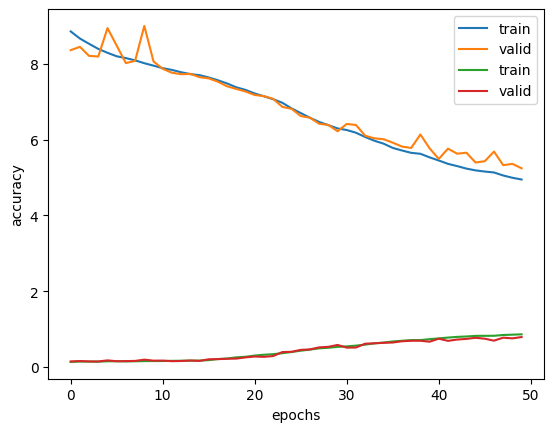

In [8]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='valid')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.plot(history_1.history['sparse_categorical_accuracy'], label='train')
plt.plot(history_1.history['val_sparse_categorical_accuracy'], label='valid')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

這一次添加了Inception V3的transfer learning，Kaggle顯示的準確率達到8成，有效地降低前幾次模型遇到的過擬合的情況。
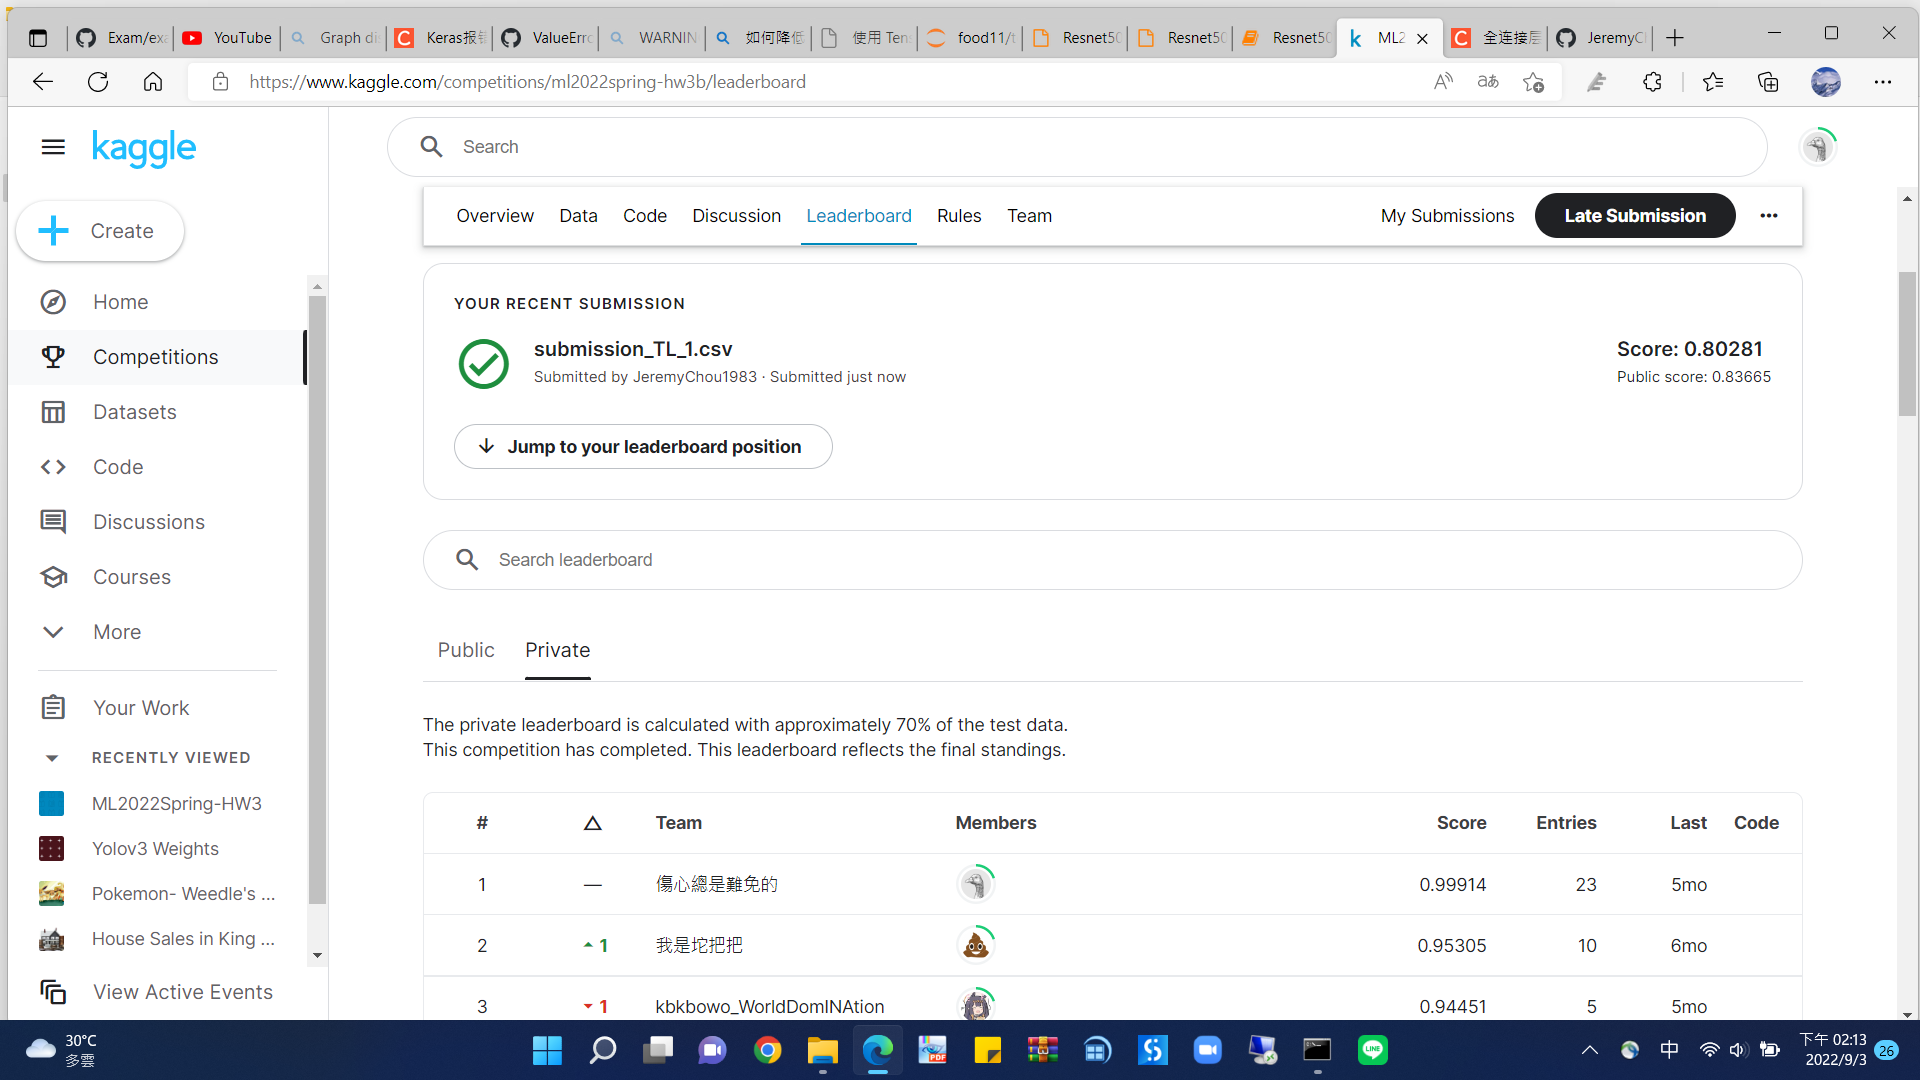